<a href="https://colab.research.google.com/github/andreschlaepfer/EEL891---IntroML/blob/main/introml_trabalho_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro ML - Trabalho 2 
## Andre Aranha Schlaepfer

### O Objetivo desse trabalho é utilizar técnicas de regressão para estimar o preço de um imóvel a partir de suas características

***Importação das dependências utilizadas e dos conjuntos de dados***

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

*Instanciando os conjuntos de dados em df_train e df_test*

In [3]:
df_train = pd.read_csv('/content/conjunto_de_treinamento.csv')
df_test =  pd.read_csv('/content/conjunto_de_teste.csv')


# Uma breve visualizacao dos dados

### Aqui começamos o pré-processamento dos dados.
### A princípio vamos apenas observá-los

In [4]:
df_train.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4643,4644,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4656,4657,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680,4681,4682
Id,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,...,6643,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653,6654,6655,6656,6657,6658,6659,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669,6670,6671,6672,6673,6674,6675,6676,6677,6678,6679,6680,6681,6682
tipo,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,...,Apartamento,Apartamento,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento
bairro,Imbiribeira,Casa Amarela,Encruzilhada,Boa Viagem,Rosarinho,Boa Vista,Rosarinho,Espinheiro,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Vista,Tamarineira,Gracas,Madalena,Boa Viagem,Parnamirim,Madalena,Boa Viagem,Boa Viagem,Boa Viagem,Gracas,S Jose,Boa Viagem,Boa Viagem,Setubal,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Madalena,Espinheiro,Parnamirim,Madalena,Arruda,...,San Martin,Rosarinho,Pina,Boa Viagem,Casa Forte,Setubal,Madalena,Casa Amarela,Campo Grande,Boa Vista,Boa Viagem,Rosarinho,Casa Forte,Boa Viagem,Imbiribeira,Torre,Boa Viagem,Espinheiro,Poco da Panela,Poco da Panela,Rosarinho,Boa Vista,Pina,Casa Amarela,Pina,Prado,Madalena,Gracas,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Torre,Boa Viagem,Setubal,Torre,Casa Amarela,Madalena
tipo_vendedor,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,...,Pessoa Fisica,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria
quartos,3,4,3,4,2,3,4,3,4,3,4,4,2,1,3,4,3,3,3,3,3,3,4,3,3,4,4,3,3,2,3,4,4,3,2,3,4,3,3,2,...,2,3,6,2,4,1,4,4,2,1,4,4,3,2,2,4,3,3,4,3,3,2,4,2,4,3,3,3,4,2,5,4,4,4,3,4,2,3,3,3
suites,3,4,1,3,1,0,2,1,4,1,3,4,0,1,1,3,1,1,1,1,3,1,2,2,1,1,4,1,1,0,0,1,1,1,1,1,4,1,1,0,...,1,1,4,1,3,1,4,1,1,0,2,2,3,2,1,3,1,0,2,2,0,2,1,1,3,1,1,1,2,2,2,2,4,2,1,4,0,1,2,1
vagas,5,2,0,2,1,1,0,1,3,1,2,3,1,2,2,4,1,1,1,2,3,1,2,2,0,2,3,1,2,1,0,2,1,2,1,2,3,2,2,1,...,1,2,4,1,3,1,3,1,1,0,2,2,3,2,0,2,2,1,2,2,2,1,2,1,2,1,1,2,2,2,2,3,2,0,2,3,1,1,3,2
area_util,223

## Matriz Correlação

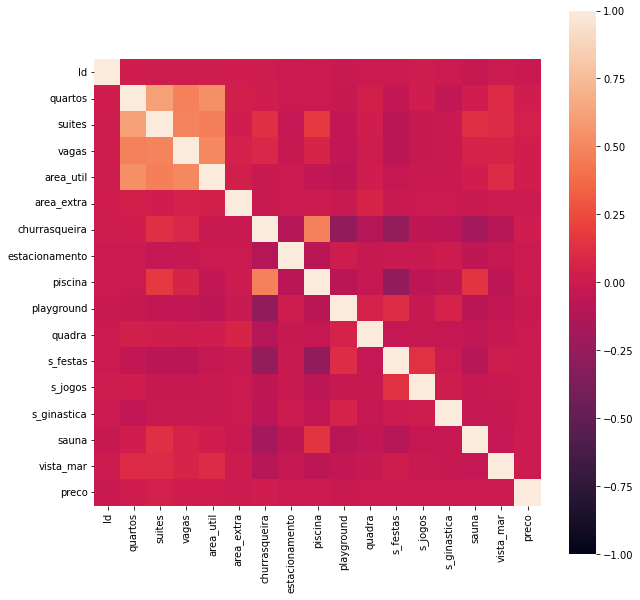

In [5]:
corrmat = df_train.corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmin=-1, vmax= 1, square=True)

### Pegamos agora apenas as 10 variáveis que possuem maior correlação com a variável alvo "preco" e montamos uma nova matriz correlação

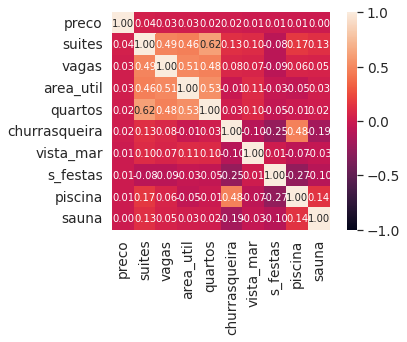

In [6]:
cols = corrmat.nlargest(10, 'preco')['preco'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, vmin=-1, vmax=1)
plt.show()

### Distribuição da variável alvo

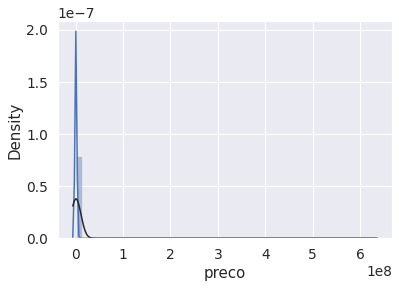

In [7]:
sns.distplot(df_train['preco'], fit=stats.norm)


#### Fica clara a presença de outliers que estão prejudicando a visualização dos dados

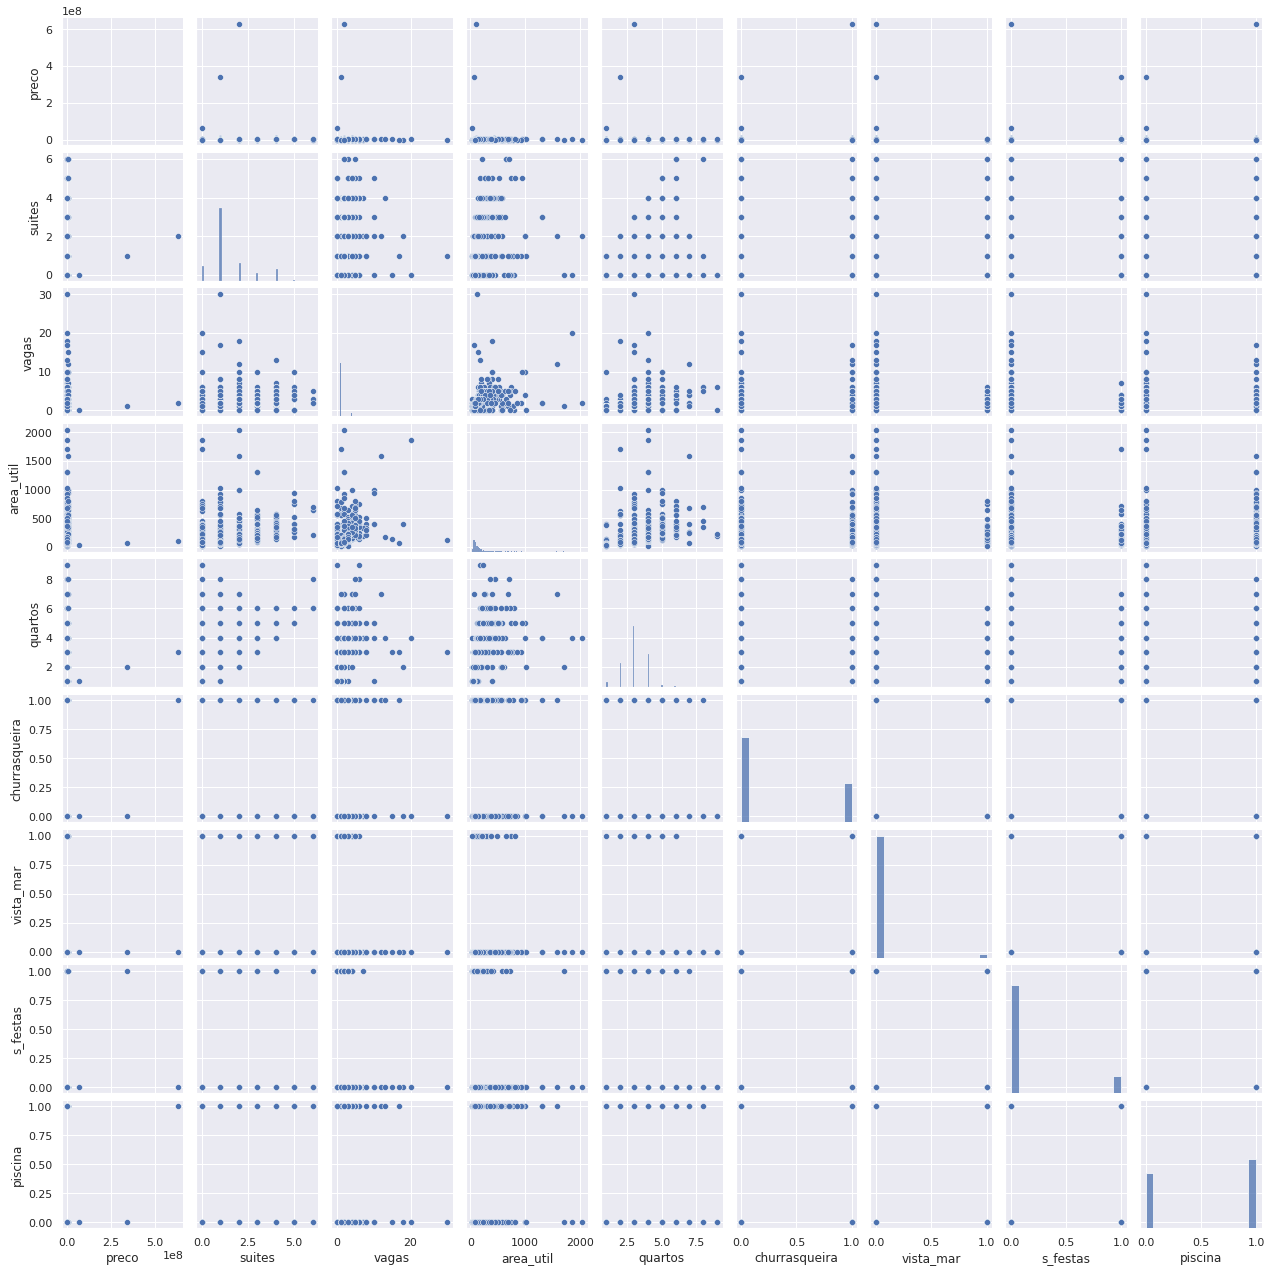

In [9]:
sns.set()
cols = ['preco', 'suites', 'vagas', 'area_util', 'quartos', 'churrasqueira', 'vista_mar', 's_festas', 'piscina']
sns.pairplot(df_train[cols], size = 2)
plt.show();

# Outliers

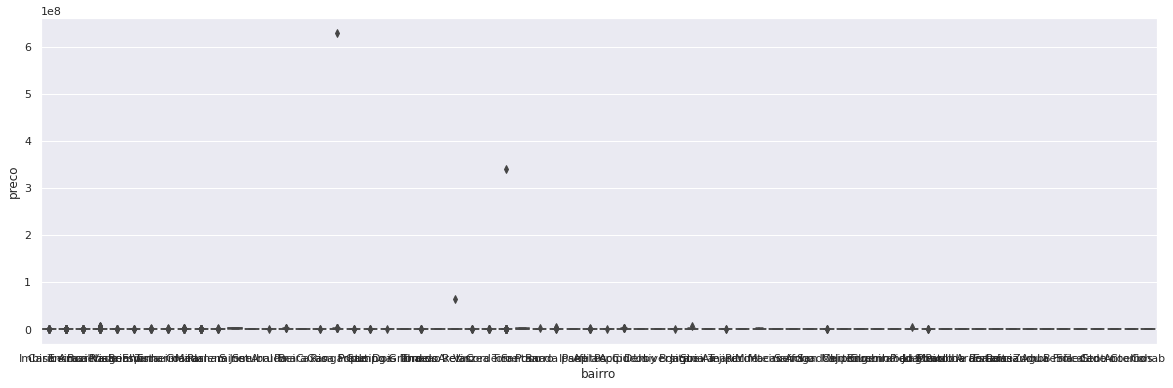

In [10]:
data = pd.concat([df_train['preco'], df_train['bairro']], axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x='bairro', y="preco", data=data)

#### É possível observar 3 outliers óbvios que estão dificultando a visualização dos dados. Vamos removê-los

In [11]:
#Deletando os outliers obvios

df_train.sort_values(by = 'preco', ascending = False)[:5]
df_train = df_train.drop(df_train[df_train['Id'] == 2405].index)
df_train = df_train.drop(df_train[df_train['Id'] == 6004].index)
df_train = df_train.drop(df_train[df_train['Id'] == 4568].index)

#### A partir do box plot, podemos analisar mais outliers

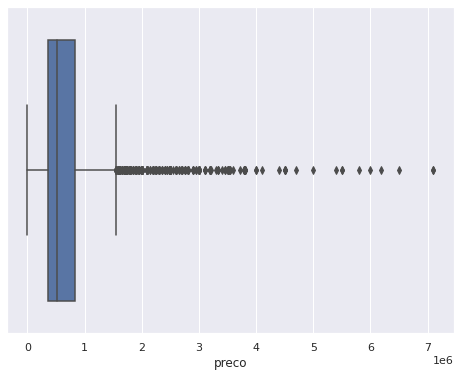

In [12]:
#Deletando mais outliers
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df_train['preco'])

#### Foi escolhido remover todas as ocorrências com preço maior que 4 milhões, pois são poucas e muito distantes da média do preço.

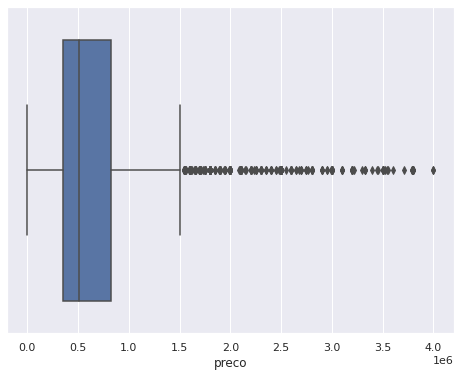

In [13]:
df_train = df_train.drop(df_train[df_train['preco'] > 4000000].index)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df_train['preco'])

# Visualizacao depois da remoção dos outliers

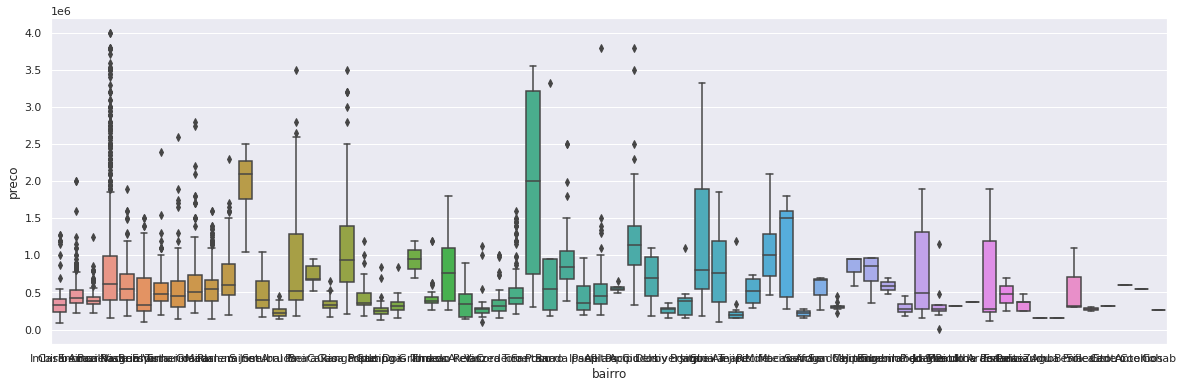

In [14]:
data = pd.concat([df_train['preco'], df_train['bairro']], axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x='bairro', y="preco", data=data)

### Agora é possível ter uma visualização dos dados mais esclarecedora.

### Vamos novamente observar a distribuição da variável alvo "preço" após a remoção dos outliers

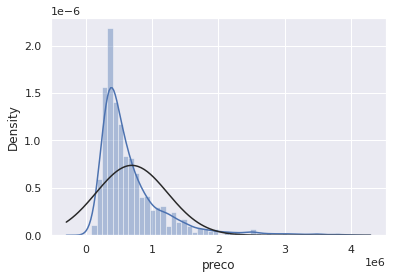

In [15]:
sns.distplot(df_train['preco'], fit=stats.norm)

#### Percebe-se que a variável não obedece a uma distribuição normal, mas lembra uma log-normal (deslocada para a esquerda). Logo, uma alternativa para normalizar a distribuição é aplicar o logaritmo sobre todos os seus pontos. Isso otimizará, posteriormente, os resultados de alguns modelos.

### Vamos, novamente, analisar as matrizes de correlação

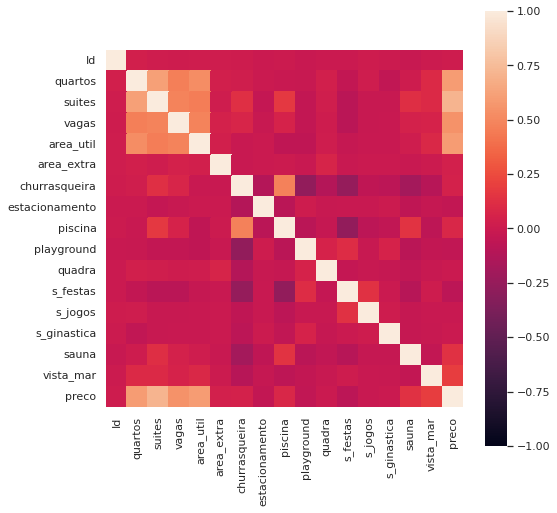

In [16]:
corrmat = df_train.corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmin=-1, vmax= 1, square=True)

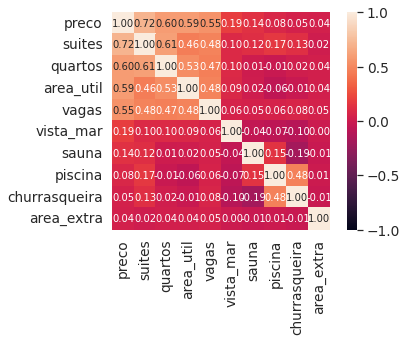

In [17]:
cols = corrmat.nlargest(10, 'preco')['preco'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, vmin=-1, vmax=1)
plt.show()

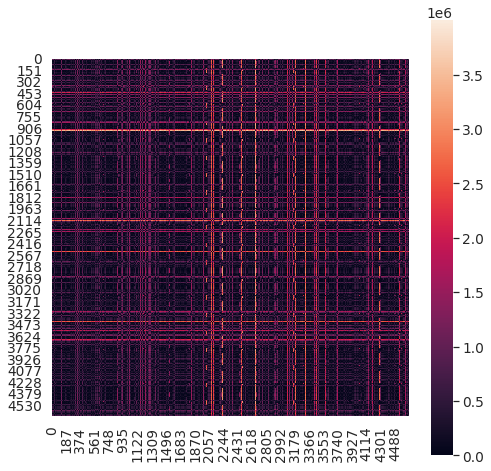

In [18]:
numcolumns = df_train.select_dtypes(include=np.number)
distmat = pd.DataFrame(distance_matrix(numcolumns.values, numcolumns.values))
plt.subplots(figsize=(8, 8))
sns.heatmap(distmat, square=True)

# Tratando dados faltantes

In [19]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percentagem'])
missing_data.head(20)

,Total,Percentagem
preco,0,0.0
diferenciais,0,0.0
tipo,0,0.0
bairro,0,0.0
tipo_vendedor,0,0.0
quartos,0,0.0
suites,0,0.0
vagas,0,0.0
area_util,0,0.0
area_extra,0,0.0


### Felizmente, não há dados ausentes

# Analisando os tipos de dados 

### Aqui vamos tratar as variáveis categóricas do conjunto

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4663 entries, 0 to 4682
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              4663 non-null   int64  
 1   tipo            4663 non-null   object 
 2   bairro          4663 non-null   object 
 3   tipo_vendedor   4663 non-null   object 
 4   quartos         4663 non-null   int64  
 5   suites          4663 non-null   int64  
 6   vagas           4663 non-null   int64  
 7   area_util       4663 non-null   int64  
 8   area_extra      4663 non-null   int64  
 9   diferenciais    4663 non-null   object 
 10  churrasqueira   4663 non-null   int64  
 11  estacionamento  4663 non-null   int64  
 12  piscina         4663 non-null   int64  
 13  playground      4663 non-null   int64  
 14  quadra          4663 non-null   int64  
 15  s_festas        4663 non-null   int64  
 16  s_jogos         4663 non-null   int64  
 17  s_ginastica     4663 non-null   i

In [21]:
df_train_cat = df_train.select_dtypes(include=['object']).copy()
cat_variables = [ i for i in df_train.columns if df_train[i].dtype == 'object']

In [22]:
df_train_cat.T.head(11)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4643,4644,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4656,4657,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680,4681,4682
tipo,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,...,Apartamento,Apartamento,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Casa,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento,Apartamento
bairro,Imbiribeira,Casa Amarela,Encruzilhada,Boa Viagem,Rosarinho,Boa Vista,Rosarinho,Espinheiro,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Vista,Tamarineira,Gracas,Madalena,Boa Viagem,Parnamirim,Madalena,Boa Viagem,Boa Viagem,Boa Viagem,Gracas,S Jose,Boa Viagem,Boa Viagem,Setubal,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Madalena,Espinheiro,Parnamirim,Madalena,Arruda,...,San Martin,Rosarinho,Pina,Boa Viagem,Casa Forte,Setubal,Madalena,Casa Amarela,Campo Grande,Boa Vista,Boa Viagem,Rosarinho,Casa Forte,Boa Viagem,Imbiribeira,Torre,Boa Viagem,Espinheiro,Poco da Panela,Poco da Panela,Rosarinho,Boa Vista,Pina,Casa Amarela,Pina,Prado,Madalena,Gracas,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Boa Viagem,Torre,Boa Viagem,Setubal,Torre,Casa Amarela,Madalena
tipo_vendedor,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,...,Pessoa Fisica,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria,Imobiliaria
diferenciais,piscina e copa,piscina e churrasqueira,nenhum,piscina e churrasqueira,piscina e churrasqueira,playground,piscina e playground,nenhum,piscina e churrasqueira,nenhum,piscina e copa,piscina e playground,nenhum,sauna e playground,nenhum,piscina e churrasqueira,nenhum,nenhum,piscina e churrasqueira,piscina e churrasqueira,piscina e sauna,piscina e churrasqueira,piscina e quadra poliesportiva,salao de festas,nenhum,campo de futebol e playground,piscina e churrasqueira,piscina e churrasqueira,piscina e churrasqueira,piscina e estacionamento visitantes,nenhum,piscina e churrasqueira,nenhum,piscina e churrasqueira,piscina e churrasqueira,piscina e sauna,copa e salao de festas,piscina e churrasqueira,piscina e churrasqueira,esquina e salao de festas,...,piscina e churrasqueira,piscina e sauna,piscina e copa,piscina e churrasqueira,piscina e churrasqueira,piscina e frente para o mar,piscina e sauna,nenhum,piscina e ch

### Para saber como vamos lidar com cada uma das variáveis categóricas, devemos verificar a cardinalidade de cada uma delas

In [23]:
#verificando a cardinalidade de cada variável categórica
print("Variável:    Qnt")
print("--------------------")
for i in cat_variables:
    categorias = df_train[i].unique()
    quantidade = len(categorias)
    print("%s: %d" % (i, quantidade))

Variável:    Qnt
--------------------
tipo: 4
bairro: 66
tipo_vendedor: 2
diferenciais: 83


## Variáveis: Cardinalidade -----> Estratégia

#### * tipo: 4 ---> ONE-HOT ENCONDING
#### * bairro: 66 ---> DESCARTAR
#### * tipo_vendedor: 2 ---> BINARIZAR
#### * diferenciais: 83 ---> DESCARTAR

In [24]:
#droppando colunas
df_train.drop(['diferenciais', 'bairro'],
  axis='columns', inplace=True)
df_test.drop(['diferenciais', 'bairro'],
  axis='columns', inplace=True)

In [25]:
#aplicando one-hot enconding

df_train = pd.get_dummies(df_train, columns=['tipo' ])
df_test = pd.get_dummies(df_test, columns=['tipo' ])

In [26]:
#aplicando binarizacao

binarizador = LabelBinarizer()

df_train['tipo_vendedor'] = binarizador.fit_transform(df_train['tipo_vendedor'])
df_test['tipo_vendedor'] = binarizador.fit_transform(df_test['tipo_vendedor'])

# Transformando os dados

### Aqui vamos aplicar o log nas variáveis que apresentam uma distribuição compatível com a lognormal, como mencionado anteriormente

# Preço

#### Antes

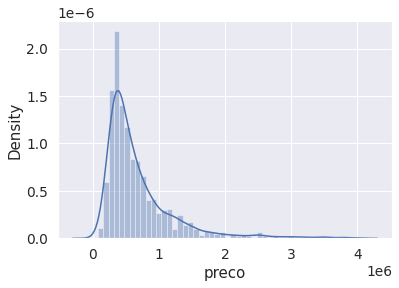

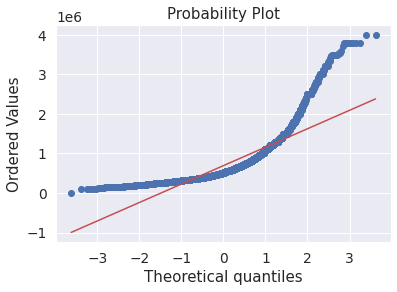

In [27]:
sns.distplot(df_train['preco']);
fig = plt.figure()
res = stats.probplot(df_train['preco'], plot=plt)

#### Aplicando o Log

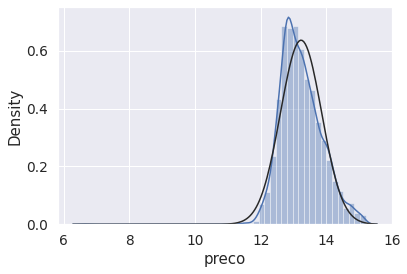

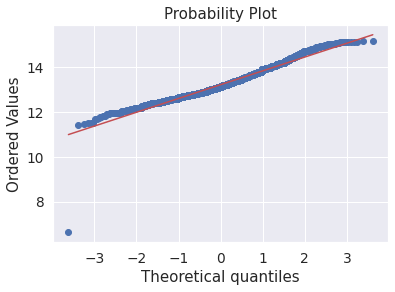

In [28]:
df_train['preco'] = np.log(df_train['preco'])
sns.distplot(df_train['preco'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['preco'], plot=plt)

# Area Útil

#### Antes

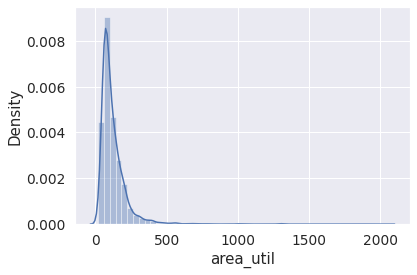

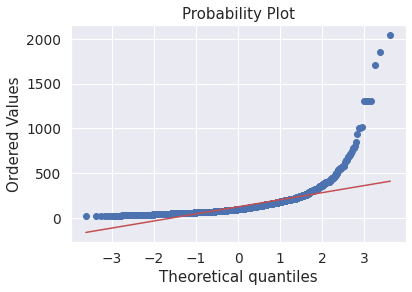

In [29]:
sns.distplot(df_train['area_util']);
fig = plt.figure()
res = stats.probplot(df_train['area_util'], plot=plt)

#### Aplicando o Log

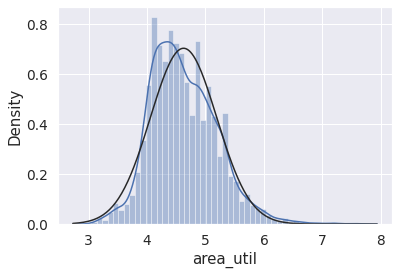

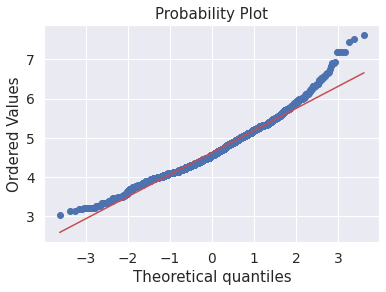

In [30]:
df_train['area_util'] = np.log(df_train['area_util'])
df_test['area_util'] = np.log(df_test['area_util'])
sns.distplot(df_train['area_util'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['area_util'], plot=plt)

In [31]:
df_train.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4643,4644,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4656,4657,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680,4681,4682
Id,2000.000000,2001.000000,2002.000000,2003.000000,2004.000000,2005.000000,2006.000000,2007.000000,2008.000000,2009.000000,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,2024.00000,2025.000000,2026.000000,2027.000000,2028.000000,2029.000000,2030.000000,2031.000000,2032.000000,2033.000000,2034.000000,2035.000000,2036.000000,2037.000000,2038.000000,2039.000000,...,6643.000000,6644.000000,6645.000000,6646.000000,6647.000000,6648.000000,6649.000000,6650.000000,6651.000000,6652.000000,6653.000000,6654.000000,6655.000000,6656.000000,6657.000000,6658.000000,6659.000000,6660.000000,6661.000000,6662.000000,6663.000000,6664.000000,6665.000000,6666.000000,6667.000000,6668.000000,6669.000000,6670.000000,6671.000000,6672.000000,6673.000000,6674.000000,6675.000000,6676.000000,6677.000000,6678.000000,6679.000000,6680.000000,6681.000000,6682.000000
tipo_vendedor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quartos,3.000000,4.000000,3.000000,4.000000,2.000000,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,2.000000,1.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.00000,4.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,4.000000,3.000000,2.000000,3.000000,4.000000,3.000000,3.000000,2.000000,...,2.000000,3.000000,6.000000,2.000000,4.000000,1.000000,4.000000,4.000000,2.000000,1.000000,4.000000,4.000000,3.000000,2.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,2.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,2.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000,2.000000,3.000000,3.000000,3.000000
suites,3.000000,4.000000,1.000000,3.000000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,3.000000,4.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,1.00000,1.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,4.000000,1.000000,3.000000,1.000000,4.000000,1.000000,1.000000,0.000000,2.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,0.000000,2.000000,2.000000,0.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000
vagas,5.000000,2.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,2.000000,2.000000,0.00000,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,...,1.000000,2.000000,4.000000,1.000000,3.000000,1.000000,3.000000,1.000000,1.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,2.000000

# Aplicando os Modelos

### Aqui vamos testar cada modelo de regressão e testá-los por meio da validação cruzada

In [32]:
label = df_train['preco']
X = df_train.drop(columns=['preco', 'Id'])
Y = df_test.drop(columns=['Id'])

kf = KFold(n_splits=5)

def cv(model, X=X):
    return -cross_val_score(model, X, label, cv=kf, scoring='neg_root_mean_squared_error')

In [33]:
linear_regression = LinearRegression(fit_intercept=False)
score = cv(linear_regression)
print("linear_regression: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

linear_regression: 0.3030 ± 0.0291


In [34]:
dtree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=8)
score = cv(dtree)
print("dtree: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

dtree: 0.3036 ± 0.0261


In [35]:
rf = RandomForestRegressor(n_estimators=200)
score = cv(rf)
print("rf: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

rf: 0.2839 ± 0.0252


In [36]:
gbr = GradientBoostingRegressor(learning_rate=0.11)
score = cv(gbr)
print("gbr: {:.4f} ± {:.4f}".format(score.mean(), score.std()))
print(score)

gbr: 0.2691 ± 0.0257
[0.24918726 0.25103172 0.26777892 0.25867594 0.31881465]


In [37]:
svr = svm.SVR(epsilon=0.05, C=0.1)
score = cv(svr)
print("svr: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

svr: 0.5930 ± 0.0338


In [38]:
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(10, 5))
score = cv(mlp)
print("mlp: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

mlp: 0.8134 ± 0.1698


# Conclusão

#### Foi possível verificar que por meio do GradientBoosting foi possível obter o melhor resultado

# Envio

In [39]:
y_train = df_train['preco'].values.ravel()
x_train = df_train.drop(columns=['preco', 'Id']).values
x_test = df_test.drop(columns=['Id'])
x_test['tipo_Quitinete'] = 0
x_test = x_test.values

gb = GradientBoostingRegressor(learning_rate=0.11)
gb = gb.fit(x_train, y_train)

y_resposta_teste = gb.predict(x_test)

In [40]:
resposta = pd.DataFrame({'Id': df_test['Id'], 'preco': y_resposta_teste})

In [41]:
resposta

,Id,preco
0,0,14.168257
1,1,12.565150
2,2,13.343738
3,3,12.668086
4,4,12.861602
...,...,...
1995,1995,13.142334
1996,1996,12.779796
1997,1997,12.878292
1998,1998,13.784944


In [42]:
resposta['preco'] = np.exp(resposta['preco'])

In [43]:
resposta

,Id,preco
0,0,1.422971e+06
1,1,2.864014e+05
2,2,6.238957e+05
3,3,3.174534e+05
4,4,3.852323e+05
...,...,...
1995,1995,5.100857e+05
1996,1996,3.549726e+05
1997,1997,3.917157e+05
1998,1998,9.698963e+05


In [44]:
resposta.to_csv('resposta_trab2.csv', index=False)  

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('introml-trabalho-2.ipynb')